In [1]:
from tslearn.utils import to_time_series_dataset
import json
import pandas as pd
import os

/home/woody/iwso/iwso092h/.venv/lib64/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
label_df = pd.read_csv('labels.csv')

In [3]:
parent_dir = '/home/vault/empkins/tpD/D02/processed_data/facemo_data'

In [4]:
ids = os.listdir(parent_dir)

In [5]:
ids = os.listdir(parent_dir)

numeric_ids = [id for id in ids if id.isdigit()]

In [6]:
valid_ids = []

# List to store DataFrames from json files
coping_list = []

# Iterate through all IDs in the directory
ids = os.listdir(parent_dir)
for id in ids:
    tagret_path = os.path.join(parent_dir, str(id), 'coping.json')
    if os.path.isfile(tagret_path):  # Check if the file exists
        try:
            with open(tagret_path, 'r') as f:
                coping_data = json.load(f)
            df = pd.DataFrame.from_dict(coping_data)
            if not df.empty:
                coping_list.append(df)
                valid_ids.append(int(id))  # Add valid ID to the list
        except (FileNotFoundError, ValueError, json.JSONDecodeError):
            pass

# Create a DataFrame from the valid IDs
id_df = pd.DataFrame({'Participant ID': valid_ids})

# Assuming combined_df is already defined and loaded
# combined_df = pd.read_excel('path_to_combined_df.xlsx') # If loaded from file

# Ensure Participant ID in combined_df is an integer
label_df['Participant ID'] = label_df['Participant ID'].astype(int)

# Merge combined_df with id_df to rearrange according to the directory IDs
reordered_df = id_df.merge(label_df, on='Participant ID', how='left')

In [7]:
reordered_df.shape

(53, 2)

In [8]:
len(coping_list)

53

In [9]:
coping_list = [df for df in coping_list if len(df) > 0]

In [10]:
y = reordered_df['Label']
y = pd.Series(y)

In [11]:
if y.isna().sum() > 0:
    print(f"Found {y.isna().sum()} NaN values in the labels. Handling them...")
    y.fillna(y.mode()[0], inplace=True)

Found 3 NaN values in the labels. Handling them...


In [12]:
y = y.apply(lambda x: 0 if x == 0.5 else x).astype(int)

In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
dataframes = coping_list

In [84]:
max_length_limit = 50000  # Example limit

# Step 1: Find the maximum length within the limit
max_length = min(max(df.shape[0] for df in dataframes), max_length_limit)

# Step 2: Trim or pad the dataframes
def pad_or_trim_dataframe(df, max_length):
    if df.shape[0] > max_length:
        return df.iloc[:max_length].to_numpy()
    else:
        padding_length = max_length - df.shape[0]
        padding = np.zeros((padding_length, df.shape[1]))
        return np.vstack([df.to_numpy(), padding])

processed_arrays = [pad_or_trim_dataframe(df, max_length) for df in dataframes]

# Step 3: Combine processed arrays into a single 3D NumPy array
data_array = np.stack(processed_arrays, axis=0)

# Check the shape of the combined array
print(f"Combined data array shape: {data_array.shape}")

# Normalize each feature across all dataframes using Z-score normalization
scaler = StandardScaler()

# Reshape data_array to (n_samples_total, n_features) for scaling
n_time_series, n_samples, n_features = data_array.shape
data_array_reshaped = data_array.reshape(-1, n_features)

# Fit and transform the data
data_array_normalized = scaler.fit_transform(data_array_reshaped)

# Reshape back to original shape (n_time_series, n_samples, n_features)
data_array_normalized = data_array_normalized.reshape(n_time_series, n_samples, n_features)

Combined data array shape: (53, 50000, 40)


In [85]:
from sklearn.model_selection import train_test_split
from tsai.all import *

X_train, X_test, y_train, y_test = train_test_split(
    data_array_normalized, y, test_size=0.20, random_state=42)

In [86]:
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

In [87]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

In [88]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)

In [61]:
# dls.show_batch(sharey=True)

In [89]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
mv_clf = TSClassifier(X, y, splits=splits, path='models', arch="InceptionTimePlus", tfms=tfms, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())
# mv_clf.fit_one_cycle(10, 1e-2)
# mv_clf.export("mv_clf.pkl")
learn = mv_clf

In [60]:
# learn.load('stage0')
# learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.730102,0.730075,0.545455,00:00
1,0.597614,0.756971,0.363636,00:00
2,0.500942,0.796812,0.272727,00:00
3,0.428485,0.887341,0.272727,00:00
4,0.370077,1.012014,0.363636,00:00
5,0.321610,1.120721,0.272727,00:00
6,0.280887,1.222604,0.363636,00:00
7,0.247241,1.319833,0.363636,00:00
8,0.219702,1.424588,0.363636,00:00
9,0.197032,1.551462,0.363636,00:00


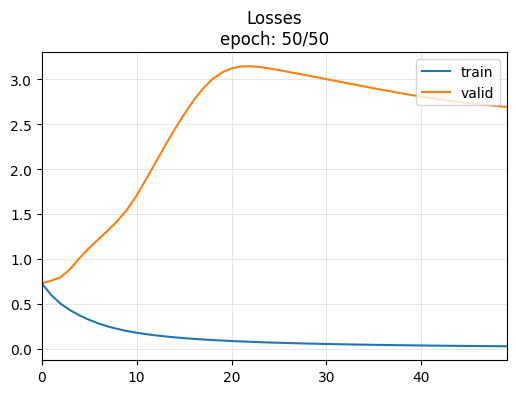

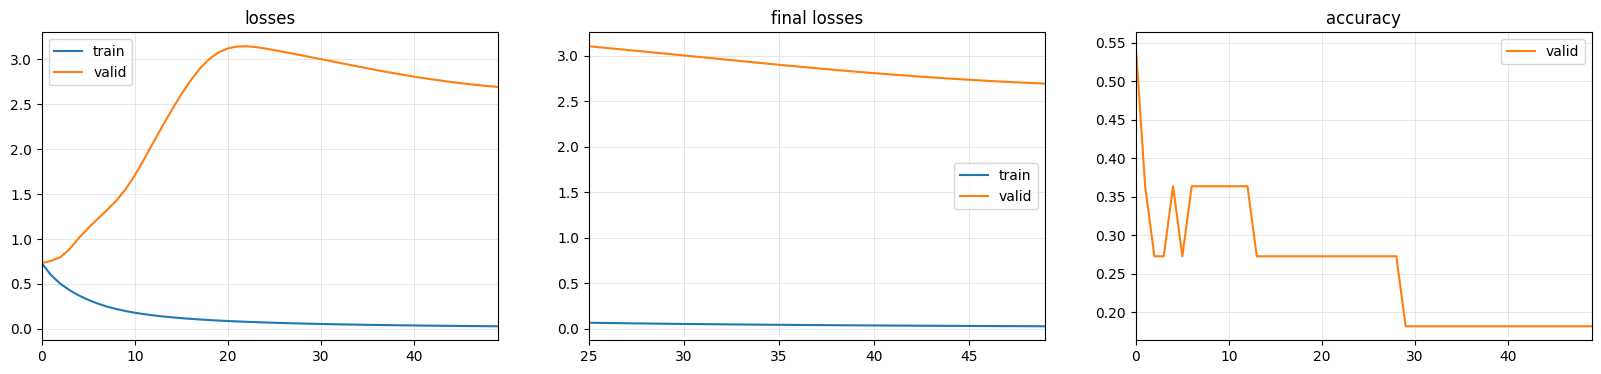

Path('models/models/stage1.pth')

In [90]:
learn.fit_one_cycle(50, lr_max=1e-3)
learn.save('stage1')

In [91]:
learn.save_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')

learn = load_learner_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')
dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))

valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)

RuntimeError: Given groups=1, weight of size [32, 10000, 1], expected input[11, 50000, 40] to have 10000 channels, but got 50000 channels instead

In [92]:
(valid_targets == valid_preds).float().mean()

tensor(0.3636)

In [59]:
# learn.show_results()

In [93]:
learn.show_probas()

RuntimeError: Given groups=1, weight of size [32, 10000, 1], expected input[11, 50000, 40] to have 10000 channels, but got 50000 channels instead

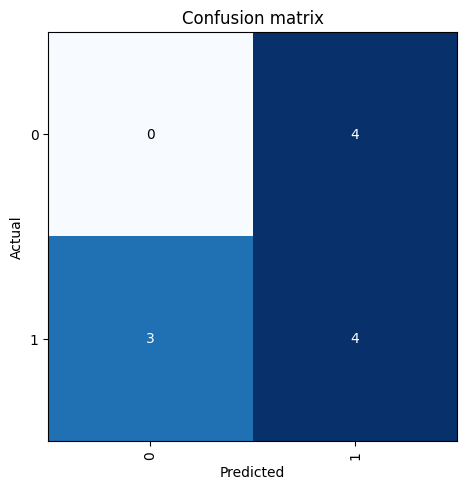

In [80]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()